In [4]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

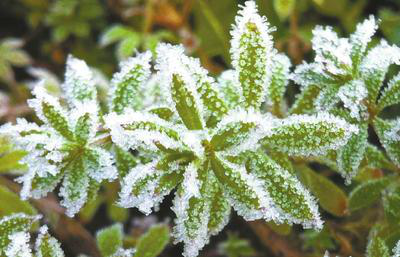

In [6]:
# Open one image from the dataset
path = 'dataset'
with Image.open(path + '/frost/3600.jpg') as img:
    display(img)

In [7]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [8]:
# Display number of classes in the dataset
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Convert dataset into CSV file

In [9]:
# List to store image paths and corresponding labels
data = []

# Loop through each label directory
for label_name in os.listdir(path):
    label_dir = os.path.join(path, label_name)
    if os.path.isdir(label_dir):
        # Loop through each image file in the label directory
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                label = label_name
                data.append((image_path, label))

# Convert the data list into a Pandas DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Save the DataFrame to a CSV file
csv_file = 'dataset.csv'  # Change the filename if desired
df.to_csv(csv_file, index=False)

In [10]:
# Load csv file and show first 5 rows
df = pd.read_csv('dataset.csv')
df.head() 

,image_path,label
0,dataset\dew\2208.jpg,dew
1,dataset\dew\2209.jpg,dew
2,dataset\dew\2210.jpg,dew
3,dataset\dew\2211.jpg,dew
4,dataset\dew\2212.jpg,dew


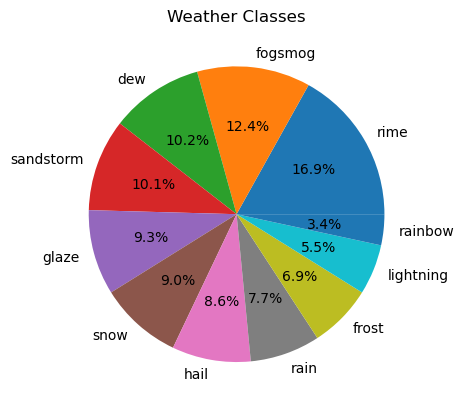

In [11]:
# Plot a pie chart to visualize % of each class in the dataset
label_counts = df["label"].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Weather Classes')
plt.show()

## Split dataset into train, validation and test sets

In [12]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size
train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

## Define transforms for each set

In [13]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply transformation mechanism for each set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5,contrast=0.3,saturation=0.5,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create data loaders for each set of data

In [14]:
# Batch size
batch = 32

# Define Data Loaders
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=True)

print("Training images available:", len(train_data))
print("\t")
print("Validation images available:", len(validation_data))
print("\t")
print("Testing images available:", len(test_data))

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [15]:
# Display one tensor from train data
train_data[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.0152, -2.0837, -2.0837],
          [-2.1179, -2.1179, -2.1179,  ..., -1.9809, -2.0494, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -1.9467, -1.9980, -2.0837],
          ...,
          [-1.7240, -1.7069, -1.7069,  ..., -1.9980, -1.9124, -1.9467],
          [-1.7412, -1.7240, -1.7240,  ..., -1.9980, -1.9124, -1.9295],
          [-1.7412, -1.7240, -1.7240,  ..., -1.9980, -1.9467, -1.9124]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0357, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0007, -2.0182],
          ...,
          [-1.6856, -1.6681, -1.6681,  ..., -2.0007, -1.9832, -2.0182],
          [-1.7031, -1.6856, -1.6856,  ..., -1.9832, -1.9657, -2.0007],
          [-1.7031, -1.6856, -1.6856,  ..., -1.9832, -1.9832, -1.9832]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.7870, -1.8044, -1.8044],
          [-1.8044, -1.8044,

Class Indexes: [ 4  0  5  2 10  4  9  6  9 10  9  5  7  2  1  0  1  5  9  4  5  7  6  4
  4  4  7  8  8  0 10  8]
	
Sample image size: torch.Size([3, 224, 224])


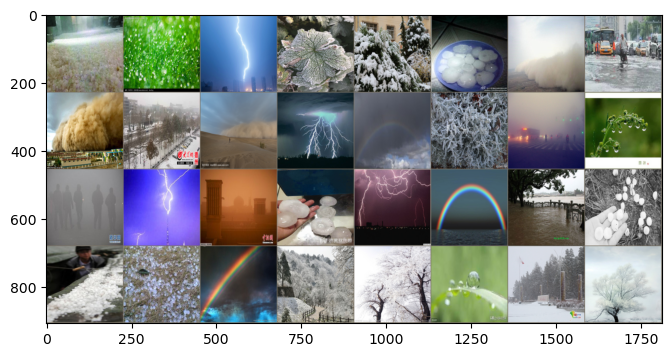

In [16]:
# Grab the first batch of 32 images
for images, labels in train_loader: 
    break

# Print the labels
print('Class Indexes:', labels.numpy())
print("\t")

# Make a grid with 8 images in each row
im = make_grid(images, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images[10].shape)

## Define the Convolutional Network (custom CNN)

In [17]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Activation layer
        x = F.relu(self.conv1(x))
        # Pooling layer
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # Apply dropout after the first fully connected layer, 
        # since it has the most parameters and is more prone to overfitting
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # Output layer
        return F.log_softmax(x, dim=1)
    

# (224/2/2) = we divided 224 by the number of conv layers by calling pooling layers,
# which leaves us at 56 pixels per side

In [18]:
# Instantiate the model, define loss and optimization functions
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)

print(CNNmodel)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
# Number of trainable parameters
def count_parameters(model):
    print("Total sum of waits in the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(CNNmodel)

Total sum of waits in the model:
	
     162
       6
     864
      16
 6021120
     120
   10080
      84
     924
      11
________
 6033387


## Train the model (custom CNN)

In [20]:
start_time = time.time()
# Number of epochs
epochs = 50

# Create lists to append losses and correct predictions per epoch
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

# Define patience, counter, best validation accuracy and
# a boolean value that determines if early stop mechanism is to be activated
patience = 8
counter = 0
best_val_acc = 0
is_early_stop = False

# For each epoch run the training and validation bathes
for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for batch, (images, labels) in enumerate(train_loader):

        # Apply the model for training
        outputs = CNNmodel(images)
        # Number of losses
        loss = criterion(outputs, labels)
 
        # Number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()
        
        # Update parameters during training
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Append losses and correct predictions per epoch 
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Calculate accuracy after each epoch
    accuracy_train = round(train_corr.item() * 100 / 4957, 3)
    
    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", accuracy_train, "%")



    
    # Run the validation batches
    CNNmodel.eval()
    
    with torch.no_grad():
        for batch, (images, labels) in enumerate(validation_loader):
            
            # Apply the model for validation
            outputs = CNNmodel(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # Number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == labels).sum()
        
        # Calculate accuracy after each epoch
        accuracy_val = round(validation_corr.item() * 100 / 875, 3)    
            
            
            
        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0
            
            # Save model with best accuracy
            torch.save(CNNmodel.state_dict(), 'BestCustomCNNModel.pt')
            
        else:
            counter += 1
            
        # Check for early stopping after the validation loop    
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                  "Validation accuracy:", accuracy_val, "%")            
            print("Early stopping triggered. Training stopped.")
            break
            
            
    # Append losses and correct predictions per epoch             
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
    
    
    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")
    

print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 1.505 Train accuracy: 29.393 %
Epoch: 1 Validation loss: 1.491 Validation accuracy: 49.6 %
best_val_acc: 49.6 counter: 0
	
Epoch: 2 Train loss: 1.086 Train accuracy: 59.29 %
Epoch: 2 Validation loss: 1.176 Validation accuracy: 64.343 %
best_val_acc: 64.343 counter: 0
	
Epoch: 3 Train loss: 0.848 Train accuracy: 72.846 %
Epoch: 3 Validation loss: 0.661 Validation accuracy: 69.829 %
best_val_acc: 69.829 counter: 0
	
Epoch: 4 Train loss: 0.535 Train accuracy: 82.126 %
Epoch: 4 Validation loss: 1.24 Validation accuracy: 70.4 %
best_val_acc: 70.4 counter: 0
	
Epoch: 5 Train loss: 0.135 Train accuracy: 89.429 %
Epoch: 5 Validation loss: 1.274 Validation accuracy: 63.657 %
best_val_acc: 70.4 counter: 1
	
Epoch: 6 Train loss: 0.05 Train accuracy: 95.32 %
Epoch: 6 Validation loss: 1.398 Validation accuracy: 71.2 %
best_val_acc: 71.2 counter: 0
	
Epoch: 7 Train loss: 0.159 Train accuracy: 97.458 %
Epoch: 7 Validation loss: 2.301 Validation accuracy: 69.143 %
best_val_acc: 71

## Evaluate model performance (custom CNN)

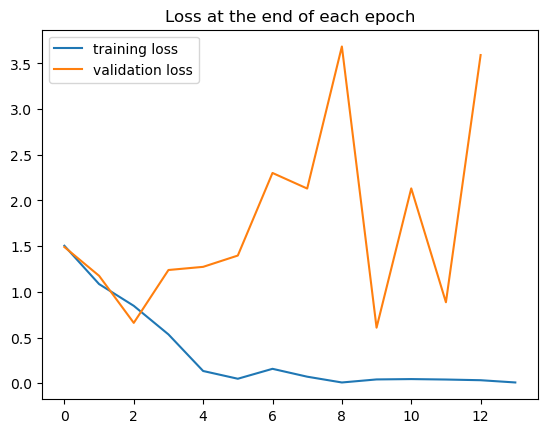

In [21]:
# Plot Losses
plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

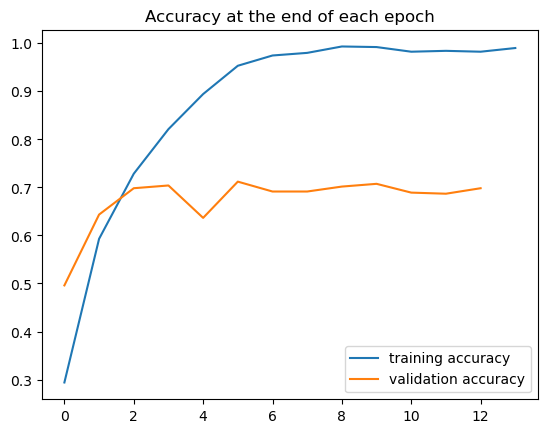

In [22]:
# Plot accuracy
plt.plot([t / 4957 for t in train_correct], label='training accuracy')
plt.plot([t / 875 for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [23]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(1457), tensor(2939), tensor(3611), tensor(4071), tensor(4433), tensor(4725), tensor(4831), tensor(4858), tensor(4924), tensor(4918), tensor(4870), tensor(4879), tensor(4870), tensor(4908)]
	
Validation Correct: [tensor(434), tensor(563), tensor(611), tensor(616), tensor(557), tensor(623), tensor(605), tensor(605), tensor(614), tensor(619), tensor(603), tensor(601), tensor(611)]


## Load saved model (custom CNN)

In [24]:
CNNmodel_best = ConvolutionalNetwork()
CNNmodel_best.load_state_dict(torch.load('BestCustomCNNModel.pt'))

<All keys matched successfully>

## Test the model (custom CNN)

In [25]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
CNNmodel_best.eval()

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_loader):

        # Apply the model for validation
        outputs = CNNmodel_best(images)
        # Number of losses
        loss = criterion(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == labels).sum()
        
    # Calculate accuracy    
    accuracy = round(test_corr.item() * 100 / 1030, 3)

test_correct.append(test_corr)

In [26]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(705)]
Test Accuracy: 68.447 %


## Confusion Matrix (custom CNN)

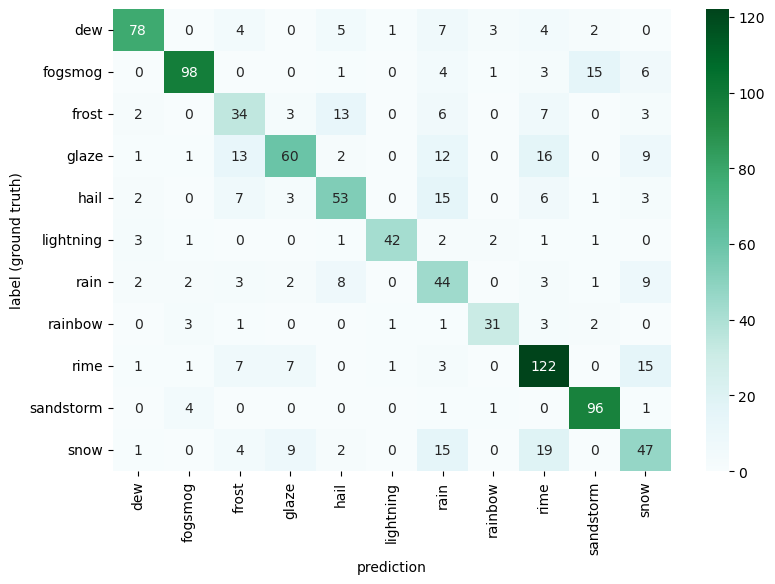

In [27]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=1030, shuffle=False)

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:
        outputs = CNNmodel_best(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Loading AlexNet model

In [28]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
# We modified the classifier so that we have 11 output features in the last linear layer instead of 1000 and
# made each Fully Connected Layer smaller
AlexNetmodel.classifier[1] = nn.Linear(9216, 512)
AlexNetmodel.classifier[4] = nn.Linear(512, 256)
AlexNetmodel.classifier[6] = nn.Linear(256, 11)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=True)
  

In [30]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

Total sum of waits in the model:
	
   23232
      64
  307200
     192
  663552
     384
  884736
     256
  589824
     256
 4718592
     512
  131072
     256
    2816
      11
________
 7322955


In [31]:
# Define loss and optimization functions
criterion_AlexNet = nn.CrossEntropyLoss()
optimizer_AlexNet = torch.optim.AdamW(AlexNetmodel.classifier.parameters(), lr=0.001)

## Train model (AlexNet)

In [32]:
start_time = time.time()
# Number of epochs
epochs = 50

# Create lists to append losses and correct predictions per epoch
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

# Define patience, counter, best validation accuracy and
# a boolean value that determines if early stop mechanism is to be activated
patience = 8
counter = 0
best_val_acc = 0
is_early_stop = False


# For each epoch run the training and validation bathes
for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for batch, (images, labels) in enumerate(train_loader):

        # Apply the model for training
        outputs = AlexNetmodel(images)
        # Number of losses
        loss = criterion_AlexNet(outputs, labels)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()
        
        # Update parameters during training
        optimizer_AlexNet.zero_grad()
        loss.backward()
        optimizer_AlexNet.step()

    # Append losses and correct predictions per epoch
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Calculate accuracy after each epoch
    accuracy_train = round(train_corr.item() * 100 / 4957, 3)
    
    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", accuracy_train, "%")


    
    
    # Run the validation batches
    AlexNetmodel.eval()
    
    with torch.no_grad():
        for batch, (images, labels) in enumerate(validation_loader):
            
            # Apply the model for validation
            outputs = AlexNetmodel(images)
            # Number of losses
            loss = criterion_AlexNet(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == labels).sum()

        # Calculate accuracy after each epoch   
        accuracy_val = round(validation_corr.item() * 100 / 875, 3)
        
            
            
        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0
            
            # Save model with best accuracy
            torch.save(AlexNetmodel.state_dict(), 'BestAlexNetmodel.pt')
        else:
            counter += 1

        # Check for early stopping after the validation loop      
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                  "Validation accuracy:", accuracy_val, "%")            
            print("Early stopping triggered. Training stopped.")
            break
            
            
    # Append losses and correct predictions per epoch       
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
        
    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")
    
    
print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 0.691 Train accuracy: 72.867 %
Epoch: 1 Validation loss: 0.112 Validation accuracy: 83.429 %
best_val_acc: 83.429 counter: 0
	
Epoch: 2 Train loss: 0.367 Train accuracy: 89.671 %
Epoch: 2 Validation loss: 0.957 Validation accuracy: 82.4 %
best_val_acc: 83.429 counter: 1
	
Epoch: 3 Train loss: 0.229 Train accuracy: 95.945 %
Epoch: 3 Validation loss: 0.38 Validation accuracy: 83.657 %
best_val_acc: 83.657 counter: 0
	
Epoch: 4 Train loss: 0.009 Train accuracy: 98.084 %
Epoch: 4 Validation loss: 0.464 Validation accuracy: 82.629 %
best_val_acc: 83.657 counter: 1
	
Epoch: 5 Train loss: 0.034 Train accuracy: 98.104 %
Epoch: 5 Validation loss: 1.446 Validation accuracy: 84.114 %
best_val_acc: 84.114 counter: 0
	
Epoch: 6 Train loss: 0.137 Train accuracy: 97.841 %
Epoch: 6 Validation loss: 0.953 Validation accuracy: 84.914 %
best_val_acc: 84.914 counter: 0
	
Epoch: 7 Train loss: 0.024 Train accuracy: 98.043 %
Epoch: 7 Validation loss: 1.589 Validation accuracy: 83.2 %
bes

## Evaluate model performance (AlexNet)

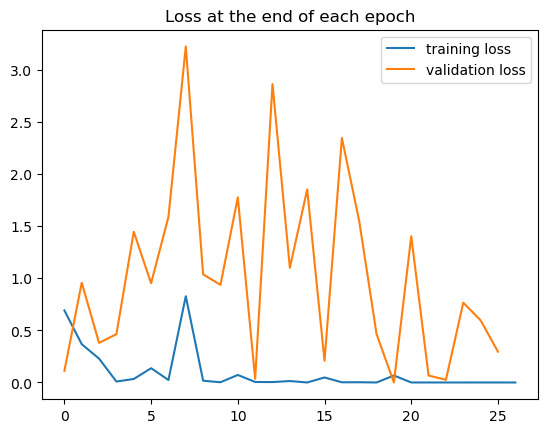

In [33]:
# Plot Losses
plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

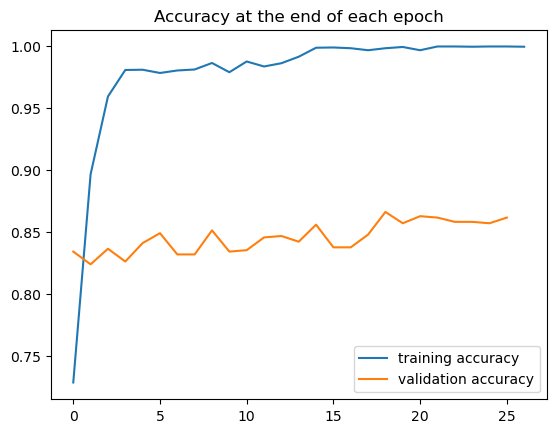

In [34]:
# Plot accuracy
plt.plot([t / 4957 for t in train_correct], label='training accuracy')
plt.plot([t / 875 for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [35]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(3612), tensor(4445), tensor(4756), tensor(4862), tensor(4863), tensor(4850), tensor(4860), tensor(4864), tensor(4890), tensor(4853), tensor(4896), tensor(4876), tensor(4889), tensor(4915), tensor(4951), tensor(4952), tensor(4949), tensor(4941), tensor(4949), tensor(4954), tensor(4941), tensor(4956), tensor(4956), tensor(4955), tensor(4956), tensor(4956), tensor(4955)]
	
Validation Correct: [tensor(730), tensor(721), tensor(732), tensor(723), tensor(736), tensor(743), tensor(728), tensor(728), tensor(745), tensor(730), tensor(731), tensor(740), tensor(741), tensor(737), tensor(749), tensor(733), tensor(733), tensor(742), tensor(758), tensor(750), tensor(755), tensor(754), tensor(751), tensor(751), tensor(750), tensor(754)]


## Load saved model (AlexNet)

In [36]:
AlexNetModel_best = models.alexnet(pretrained=True)

AlexNetModel_best.classifier[1] = nn.Linear(9216, 512)
AlexNetModel_best.classifier[4] = nn.Linear(512, 256)
AlexNetModel_best.classifier[6] = nn.Linear(256, 11)

AlexNetModel_best.load_state_dict(torch.load('BestAlexNetmodel.pt'))

<All keys matched successfully>

## Test the model (AlexNet)

In [37]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
AlexNetModel_best.eval()

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_loader):

        # Apply the model for validation
        outputs = AlexNetModel_best(images)
        # Number of losses
        loss = criterion_AlexNet(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == labels).sum()
    
    # Calculate accuracy
    accuracy = round(test_corr.item() * 100 / 1030, 3)

test_correct.append(test_corr)

In [38]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(893)]
Test Accuracy: 86.699 %


## Confusion Matrix (AlexNet)

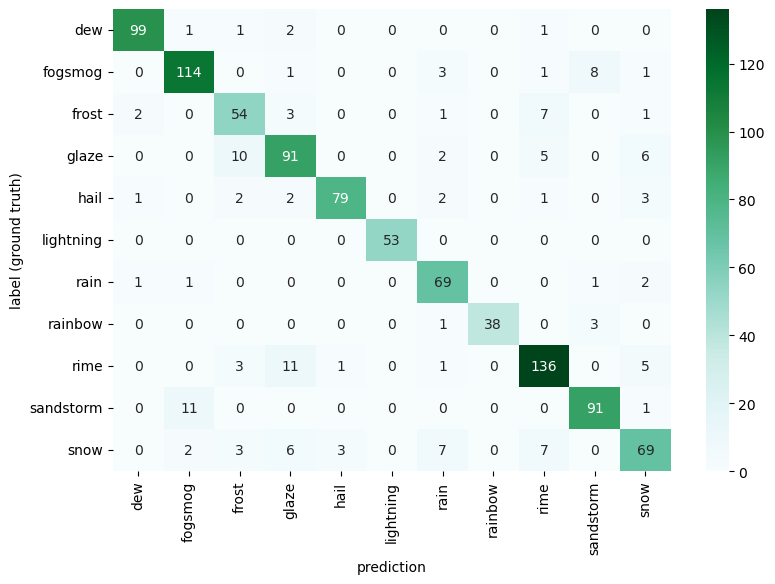

In [39]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=1030, shuffle=False)

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:
        outputs = AlexNetModel_best(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Custom CNN model prediction: 7
	
AlexNet model prediction: 7


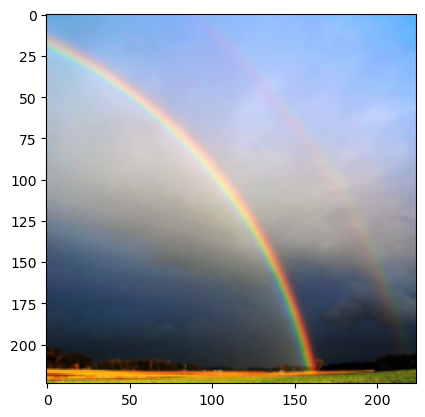

In [41]:
# Open a custom image
custom_img = Image.open('custom_images/1.jpg')

# Define transformations for the image
transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

# Inverse normalize the image
custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

print("Classes:", classes)
print("\t")

# CNN Model Prediction:
CNNmodel_best.eval()
with torch.no_grad():
    custom_pred = CNNmodel_best(custom_img_t.view(1,3,224,224)).argmax()
    
print("Custom CNN model prediction:", custom_pred.item())
print("\t")


# AlexNet Model Prediction:
AlexNetModel_best.eval()
with torch.no_grad():
    custom_pred = AlexNetModel_best(custom_img_t.view(1,3,224,224)).argmax()
    
print("AlexNet model prediction:", custom_pred.item())